In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA

try:
    import seaborn as sns
except ImportError:
    %pip install seaborn
    import seaborn as sns

try:
    from word2number import w2n
except ImportError:
    %pip install word2number
    from word2number import w2n

import matplotlib.pyplot as plt
from scipy import stats

# Loading Data

In [2]:
#Load Dataset
dataset = pd.read_csv('customer_dataset.csv')
print("------------------------- CUSTOMER DATASET -----------------------------")
print(dataset.head())
print("-------------------------------------------------------------------------")

------------------------- CUSTOMER DATASET -----------------------------
   customer_id average_monthly_spend average_monthly_visit_frequency  \
0            1                   790                            1.11   
1            2                176875                           15.74   
2            3                  6812                            2.11   
3            4                 38542                            7.82   
4            5                 48712                            7.51   

   average_monthly_basket_size  
0                         2.84  
1                        33.83  
2                          NaN  
3                        10.73  
4                        10.04  
-------------------------------------------------------------------------


C:\Users\msi\AppData\Local\Temp\ipykernel_7088\1984632898.py:2: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('customer_dataset.csv')


# Dealing with Non Numeric Data

In [3]:
#print all non numeric columns
print("----------------------- NON NUMERIC COLUMNS----------------------------")
for i in dataset.columns:
    if dataset[i].dtype == 'object':
        print(i,end = " ")
print()
print("-----------------------------------------------------------------------")
#handling non-numeric data converting them to numeric
def word_to_num(value):
    try:
        return w2n.word_to_num(value)
    except ValueError:
        if value.isdigit():
            return int(value)
        elif value.replace('.', '', 1).isdigit() and value.count('.') < 2:
            return float(value)
        return None

for column in dataset.columns:
    dataset[column] = dataset[column].apply(lambda x : word_to_num(str(x)))

----------------------- NON NUMERIC COLUMNS----------------------------
average_monthly_spend average_monthly_visit_frequency 
-----------------------------------------------------------------------


# Prelimenary Analysis of Missing Values

--------------------------- MISSING VALUE DETAILS ----------------------------------
customer_id                           0
average_monthly_spend              9389
average_monthly_visit_frequency    9337
average_monthly_basket_size        9287
dtype: int64
Length of dataset: 570000
Rows with nan values: 28013
Ratio of rows with nan values: 5.0%


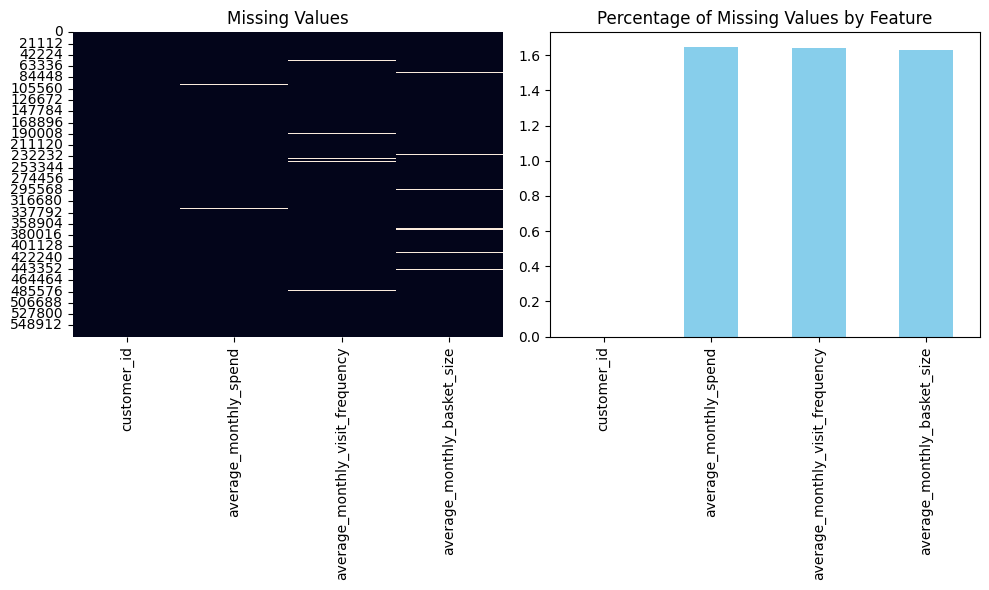

---------------------------------------------------------------------------------------


In [4]:
#missing value analysis
print("--------------------------- MISSING VALUE DETAILS ----------------------------------")
#nan count
print(dataset.isna().sum())
#length of dataset
print(f"Length of dataset: {len(dataset)}")
#count all the rows with nan values
rows_with_nan = dataset.isna().any(axis=1).sum()
print(f"Rows with nan values: {rows_with_nan}")
#ratio of rows with nan values
missing_percentage = dataset.isnull().mean() * 100
print(f"Ratio of rows with nan values: {round(rows_with_nan/len(dataset),2)*100}%")

plt.figure(figsize=(5,5))
plt.subplot(1, 2, 1)
plt.title('Missing Values')
sns.heatmap(dataset.isnull(), cbar=False)

plt.subplot(1, 2, 2)
missing_percentage.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Percentage of Missing Values by Feature')
plt.tight_layout()
plt.show()
print("---------------------------------------------------------------------------------------")

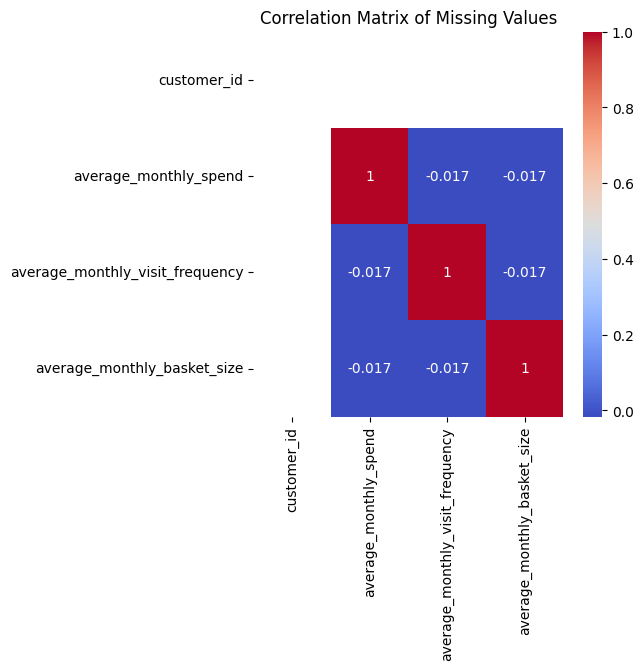

In [5]:
#correlation matrix to see the missing values are correlated
plt.figure(figsize=(5, 5))
corr_matrix = dataset.isnull().corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Missing Values')
plt.show()

In [6]:
#extract nan rows from dataset for further analysis
nan_rows = dataset[dataset.isnull().any(axis=1)]
#replace nan with 0
dataset.dropna(inplace=True)
# Handle duplicates
dataset.drop_duplicates(inplace=True)

print("------------------- EXTRACTED NAN ROWS ----------------------")
print(nan_rows)
print("--------------------------------------------------------------")

------------------- EXTRACTED NAN ROWS ----------------------
        customer_id  average_monthly_spend  average_monthly_visit_frequency  \
2                 3                 6812.0                             2.11   
7                 8                12656.0                             2.13   
24               25                41329.0                              NaN   
52               53               171010.0                              NaN   
53               54               104457.0                            18.88   
...             ...                    ...                              ...   
559914       559915                45023.0                              NaN   
559945       559946                49533.0                             5.87   
559959       559960                    NaN                             5.80   
559970       559971                95444.0                            19.85   
559972       559973                13981.0                           

In [7]:
def plot_outliers():
  iso_forest = IsolationForest(contamination=0.05, random_state=42)
  features = ['average_monthly_spend','average_monthly_visit_frequency','average_monthly_basket_size']
  data = dataset.copy()
  iso_forest.fit(data[features])
  outliers = iso_forest.predict(data[features])
  data['outlier'] = outliers
  outliers_data = data[data['outlier'] == -1]
  sns.pairplot(data, hue='outlier', palette={1: 'blue', -1: 'red'}, markers=["o", "s"])
  plt.suptitle('Isolation Forest Outlier Detection', y=1.02)
  plt.show()

In [8]:
#Handle outliers
data = dataset.copy()
Q1 = dataset.quantile(0.25)
Q3 = dataset.quantile(0.75)
IQR = Q3 - Q1
outliers = ((dataset < (Q1 - 1.5 * IQR)) | (dataset > (Q3 + 1.5 * IQR))).any(axis=1)
dataset = dataset[~outliers]

copy_dataset = dataset.copy()
data.describe()

,customer_id,average_monthly_spend,average_monthly_visit_frequency,average_monthly_basket_size
count,531990.000000,5.319900e+05,531990.000000,531990.000000
mean,280059.070229,4.825899e+04,6.879288,13.292845
std,161689.312262,9.173203e+04,5.323171,12.039045
min,1.000000,0.000000e+00,0.000000,0.000000
25%,139927.250000,1.049900e+04,2.390000,3.800000
50%,280109.500000,3.195900e+04,5.600000,9.790000
75%,420171.750000,8.541800e+04,9.850000,17.480000
max,560000.000000,4.833000e+07,432.740000,385.040000


# Data Visualization and Preliminary Clusterting for Observing the Nature of Decision Boundaries

In [9]:
#scale for cluster visualization
scaler = StandardScaler()
scaled_data = scaler.fit_transform(dataset.iloc[:, 1:])
scaled_data_nan = scaler.transform(nan_rows.iloc[:, 1:])

In [10]:
#clustering using Kmeans
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

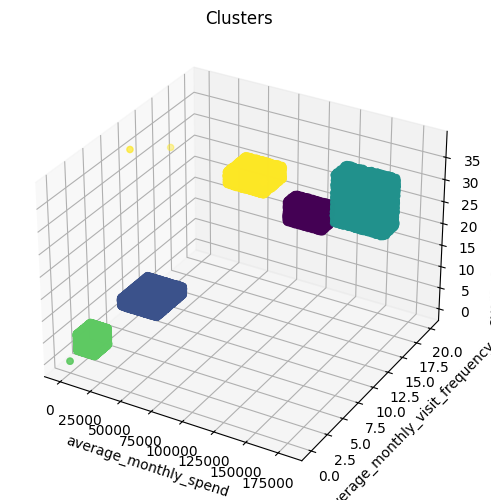

In [11]:
nan_rows.fillna(0, inplace=True)
dataset['Cluster'] = clusters
fig = plt.figure(figsize=(13, 12))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(dataset['average_monthly_spend'], dataset['average_monthly_visit_frequency'], dataset['average_monthly_basket_size'], c=clusters, cmap='viridis')
ax.set_xlabel('average_monthly_spend')
ax.set_ylabel('average_monthly_visit_frequency')
ax.set_zlabel('average_monthly_basket_size')
plt.title('Clusters')
ax.set_xlabel('average_monthly_spend')
ax.set_ylabel('average_monthly_visit_frequency')
ax.set_zlabel('average_monthly_basket_size')

plt.show()

Cuboidal shape of the clusters is proof that the Decision boundaries can be repressented as a logical combination of coniditions on eack parameter seperately. (The decision Boundaries are alined with the Vertical and Horizontal Planes). That is the Function for a Decison Boundary for a cluster $j$, $\phi_j(x_1,x_2,x_2)$ (where $x_1,x_2,x_3$ are the three features) can be expressed as a logical combination of three simple decision rules.

That is if,
$$
\phi_j(x_1,x_2,x_3) = 
\begin{cases} 
1 & \text{If belongs to cluster j} \\
0 & \text{If does not belongs to cluster j}
\end{cases}\\
$$
then,
$$
\phi_j(x_1,x_2,x_3) = \phi_{1,j}(x_1) \cdot \phi_{2,i}(x_2) \cdot \phi{3,i}(x_3)\\
$$

where $\cdot$ is the logical and operation fruthemore since there is only one such block per cluster per axis,
$$
\phi_{k,j}(x_k) = 
\begin{cases} 
1 & a_k<x_k<b_k\\
0 & \text{otherwise}
\end{cases}\\
$$

Where $a_k$ and $b_k$ are to be determined Finally it can also be observed that these margins are far apart so clustering in each dimension seperately is sufficient for identifying these bondaries.

Finally this corrabartes well with the Problem Statement




# Demonstrating that Rows with Missing Values Belong to One of the Clusters and Can be Fully Determined by Coonsidering the remaining Columns

We will use the fact that if we make one of the features zero, this produces a Projection of one of the Cuboidal Clusters onto one of the planes. Therefore, we will replace the missing values with zero and plot in a 3d space

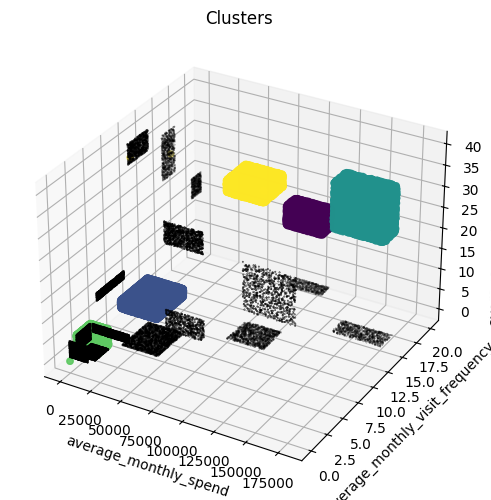

In [12]:

nan_rows.fillna(0, inplace=True)
dataset['Cluster'] = clusters
fig = plt.figure(figsize=(13, 12))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(dataset['average_monthly_spend'], dataset['average_monthly_visit_frequency'], dataset['average_monthly_basket_size'], c=clusters, cmap='viridis')
ax.set_xlabel('average_monthly_spend')
ax.set_ylabel('average_monthly_visit_frequency')
ax.set_zlabel('average_monthly_basket_size')
plt.title('Clusters')
ax.scatter(nan_rows['average_monthly_spend'], nan_rows['average_monthly_visit_frequency'], nan_rows['average_monthly_basket_size'],
           c='black',s = 0.1)
ax.set_xlabel('average_monthly_spend')
ax.set_ylabel('average_monthly_visit_frequency')
ax.set_zlabel('average_monthly_basket_size')

plt.show()

We can easily see that all of the missing value clouds (Black data clouds) are simply projections of the already identified clusters onto on of the planse $x_1x_2$,$x_1x_3$,$x_2x_3$ planes thus proving our claim is correct. We will reinforce this claim in later sections. Finally, since all Black Data clouds are 2 Dimensional it is also clear that there are no columns with two or more missing values.

# Demonstrating that the Distribution Roughly Follows the Rules given in the Problem Statement

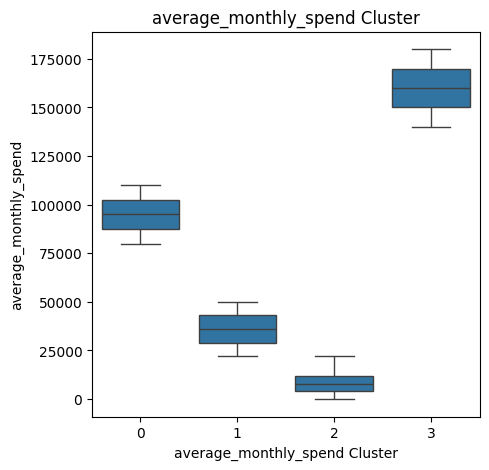

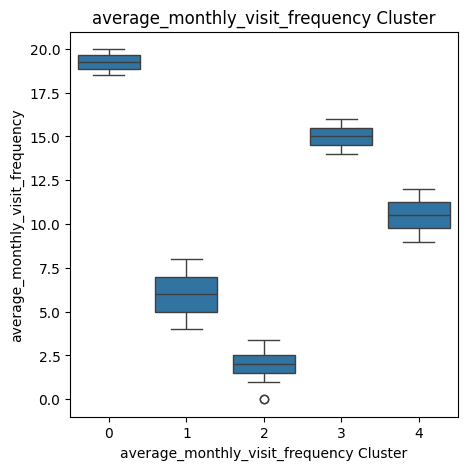

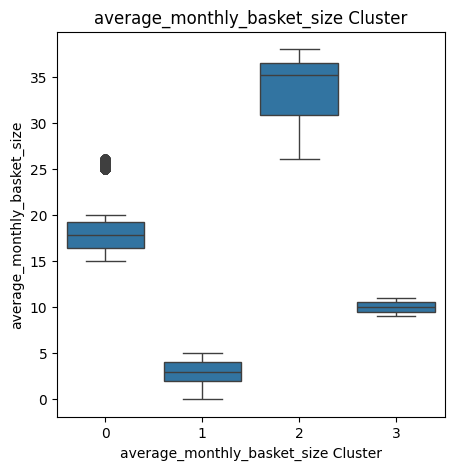

In [13]:

def cluster_visualization_on_feature(feature_name:str):
    feature_dataset = copy_dataset[[feature_name]].dropna()
    n = 5 if feature_name == "average_monthly_visit_frequency" else 4
    kmeans = KMeans(n_clusters=n, random_state=42)
    clusters = kmeans.fit_predict(feature_dataset)
    feature_dataset[f'{feature_name} Cluster'] = clusters
    plt.figure(figsize=(5, 5))
    sns.boxplot(x=f'{feature_name} Cluster', y=feature_name, data=feature_dataset)
    plt.title(f'{feature_name} Cluster')
    plt.show()

cluster_visualization_on_feature('average_monthly_spend')
cluster_visualization_on_feature('average_monthly_visit_frequency')
cluster_visualization_on_feature('average_monthly_basket_size')


Plotting Box and Whisker graphs to analyze distinct clusters within features.
Considering Average Monthly Spend by Cluster,We can identify there are 4 distinct clusters (cluster 0 and 4 are the same). We could categorize them as,
- 3 - LOW
- 1 - Average
- 0, 4 - High
- 2 - Very High

Considering Average Monthly Visit Frequency by cluster, We can identify that there are 5 distinct clusters. We can categorize them as,

- 3 - Low
- 1 - Average Lower
- 4 - Average Higher
- 2 - High
- 1 - Very High

Note that we can see two well separated clusters in the average range instead of the one as given in the problem statement. It is possible that these two clusters have no bearing on the problem. But we will later show that these have a very high importance for the classification task.
Considering Average Monthly Basket Size by cluster.Although we can see 5 clusters in the plot we can see that the two upper clusters are overlapping in terms of the inter quartile ranges. Therefore will only consider four clusters. We can categorize them as ,

- 3 - Low
- 1 - Average
- 0 - High
- 2,4 - Very High

The Table is mostly correct however there are some modifications need to be done which we will further verify and update in a later section

# Analyzing Each Feature Set Independantly and Identifying the Percentiles (Ranges in our Case)

Since in the previous section we demonstrated that it is sufficient to analyze each feature independantly we wil analyze them,
- first visually through histograms
- second using 

In [14]:
print("----------------------------Data Analysis----------------------------")

data = pd.read_csv('customer_dataset.csv')
data.head()

----------------------------Data Analysis----------------------------


C:\Users\msi\AppData\Local\Temp\ipykernel_7088\3996165402.py:3: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('customer_dataset.csv')


,customer_id,average_monthly_spend,average_monthly_visit_frequency,average_monthly_basket_size
0,1,790,1.11,2.84
1,2,176875,15.74,33.83
2,3,6812,2.11,NaN
3,4,38542,7.82,10.73
4,5,48712,7.51,10.04


In [15]:
# Extracting columns from the dataframe
col_names = data.columns.tolist()
print(col_names)

['customer_id', 'average_monthly_spend', 'average_monthly_visit_frequency', 'average_monthly_basket_size']


In [16]:
# Converting words to numerical values
def convert_word_to_number(amount):
    try:
        return w2n.word_to_num(amount)
    except ValueError:
        return amount

for col in col_names:
    data[col] = data[col].apply(convert_word_to_number)
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data = data.dropna(subset=[col])

In [17]:
def plot_barCharts(column_name, x_axis_label, interval_width : int, min_limit : int, max_limit : int):
  max_value = int(data[column_name].max()) + interval_width

  bins = range(min_limit, max_limit, interval_width)
  labels = [f'{i}-{i+interval_width}' for i in bins[:-1]]

  data['range'] = pd.cut(data[column_name], bins=bins, labels=labels, right=False)
  customer_count = data['range'].value_counts().sort_index()

  plt.figure(figsize=(12, 6))
  customer_count.plot(kind='bar')
  plt.xlabel(x_axis_label)
  plt.ylabel('Number of Customers')
  plt.title(f'Number of Customers in Each {x_axis_label} Range')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

  print(customer_count)

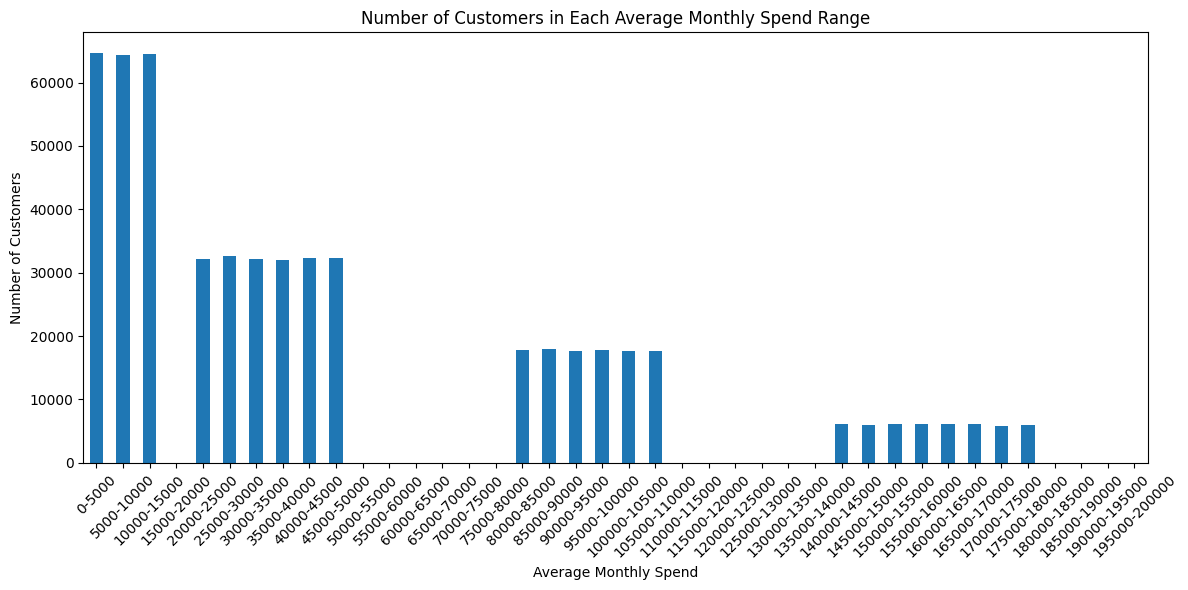

range
0-5000           64687
5000-10000       64284
10000-15000      64552
15000-20000          0
20000-25000      32134
25000-30000      32692
30000-35000      32145
35000-40000      32006
40000-45000      32371
45000-50000      32357
50000-55000          0
55000-60000          0
60000-65000          0
65000-70000          0
70000-75000          0
75000-80000          0
80000-85000      17794
85000-90000      17918
90000-95000      17680
95000-100000     17782
100000-105000    17605
105000-110000    17601
110000-115000        0
115000-120000        0
120000-125000        0
125000-130000        0
130000-135000        0
135000-140000        0
140000-145000     6057
145000-150000     5982
150000-155000     6146
155000-160000     6188
160000-165000     6173
165000-170000     6061
170000-175000     5856
175000-180000     5918
180000-185000        0
185000-190000        0
190000-195000        0
195000-200000        0
Name: count, dtype: int64


In [18]:
plot_barCharts('average_monthly_spend', 'Average Monthly Spend', 5000, 0, 200001)

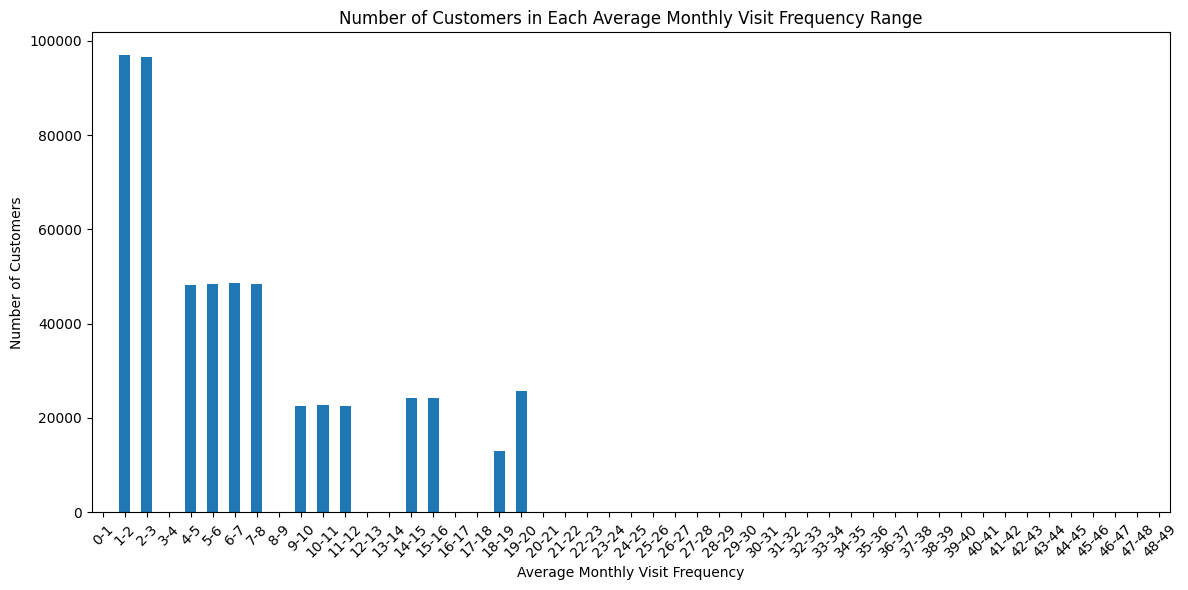

range
0-1          2
1-2      96944
2-3      96575
3-4          1
4-5      48285
5-6      48346
6-7      48647
7-8      48423
8-9          0
9-10     22447
10-11    22718
11-12    22519
12-13        0
13-14        0
14-15    24151
15-16    24235
16-17        0
17-18        0
18-19    12928
19-20    25766
20-21        0
21-22        0
22-23        1
23-24        0
24-25        0
25-26        0
26-27        0
27-28        0
28-29        0
29-30        0
30-31        0
31-32        0
32-33        0
33-34        0
34-35        0
35-36        0
36-37        0
37-38        0
38-39        0
39-40        0
40-41        0
41-42        0
42-43        0
43-44        0
44-45        0
45-46        0
46-47        0
47-48        0
48-49        0
Name: count, dtype: int64


In [19]:
plot_barCharts('average_monthly_visit_frequency', 'Average Monthly Visit Frequency', 1, 0, 50)

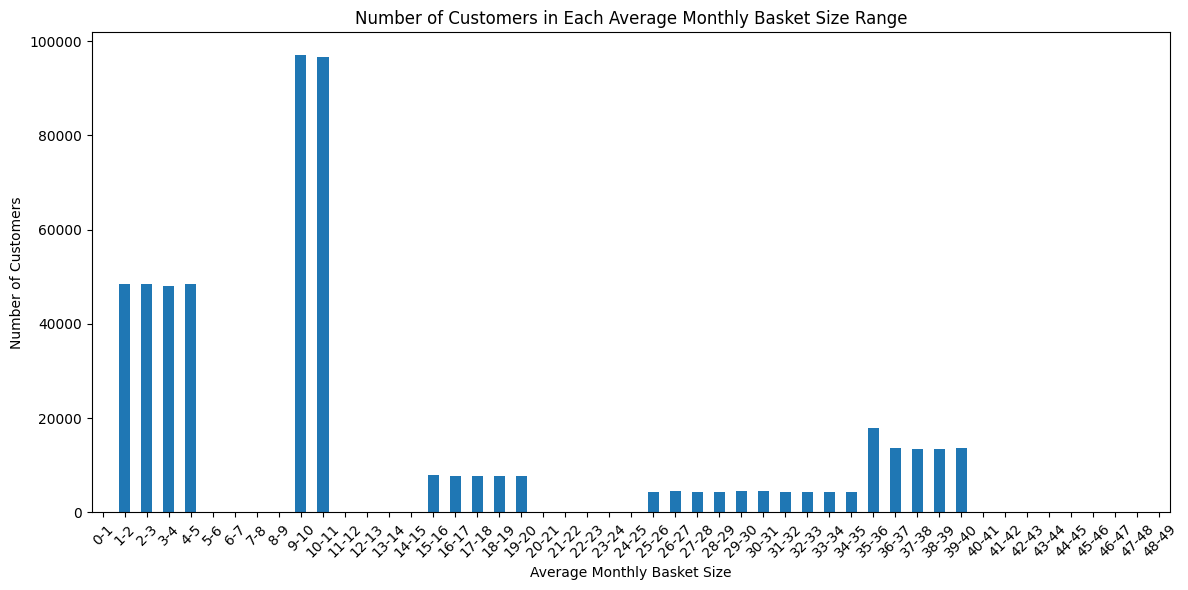

range
0-1          3
1-2      48568
2-3      48458
3-4      48130
4-5      48366
5-6          0
6-7          0
7-8          0
8-9          0
9-10     97051
10-11    96656
11-12        0
12-13        0
13-14        0
14-15        0
15-16     7824
16-17     7632
17-18     7771
18-19     7709
19-20     7758
20-21        0
21-22        0
22-23        0
23-24        0
24-25        0
25-26     4400
26-27     4505
27-28     4346
28-29     4374
29-30     4480
30-31     4440
31-32     4356
32-33     4408
33-34     4343
34-35     4352
35-36    17985
36-37    13562
37-38    13471
38-39    13460
39-40    13587
40-41        0
41-42        0
42-43        0
43-44        0
44-45        0
45-46        0
46-47        0
47-48        0
48-49        0
Name: count, dtype: int64


In [20]:
plot_barCharts('average_monthly_basket_size', 'Average Monthly Basket Size', 1, 0, 50)

# Further Proving that rows with Missing Values Follow the Same Distribution as the other ones

In [21]:
# Now we'll try to analyze data by removing only the N/A entries in the respective column

dataset = pd.read_csv('customer_dataset.csv')

C:\Users\msi\AppData\Local\Temp\ipykernel_7088\1354000501.py:3: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv('customer_dataset.csv')


In [22]:
col_names = dataset.columns.tolist()
print(col_names)

['customer_id', 'average_monthly_spend', 'average_monthly_visit_frequency', 'average_monthly_basket_size']


In [23]:
for col in col_names:
    dataset[col] = dataset[col].apply(convert_word_to_number)
    dataset[col] = pd.to_numeric(dataset[col], errors='coerce')

In [24]:
def plot_barCharts_2(column_name, x_axis_label, interval_width : int, min_limit : int, max_limit : int):
  data = dataset.dropna(subset=[column_name])
  max_value = int(data[column_name].max()) + interval_width

  bins = range(min_limit, max_limit, interval_width)
  labels = [f'{i}-{i+interval_width}' for i in bins[:-1]]

  data['range'] = pd.cut(data[column_name], bins=bins, labels=labels, right=False)
  customer_count = data['range'].value_counts().sort_index()

  plt.figure(figsize=(12, 6))
  customer_count.plot(kind='bar')
  plt.xlabel(x_axis_label)
  plt.ylabel('Number of Customers')
  plt.title(f'Number of Customers in Each {x_axis_label} Range')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

  print(customer_count)

C:\Users\msi\AppData\Local\Temp\ipykernel_7088\4100806091.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['range'] = pd.cut(data[column_name], bins=bins, labels=labels, right=False)


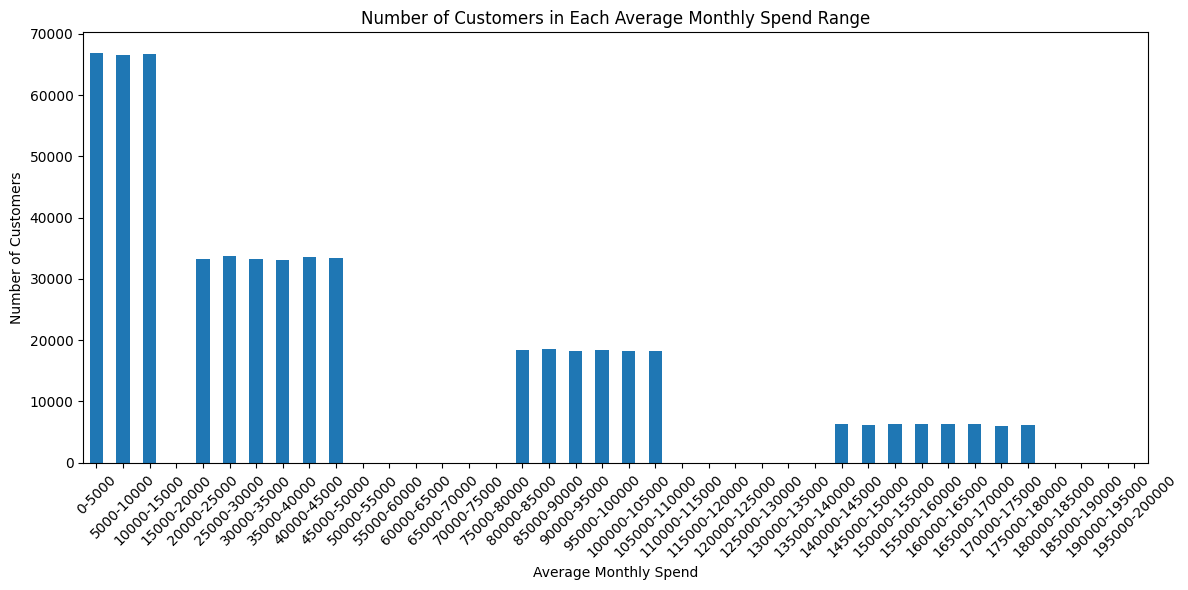

range
0-5000           66892
5000-10000       66494
10000-15000      66722
15000-20000          0
20000-25000      33268
25000-30000      33795
30000-35000      33218
35000-40000      33105
40000-45000      33501
45000-50000      33424
50000-55000          0
55000-60000          0
60000-65000          0
65000-70000          0
70000-75000          0
75000-80000          0
80000-85000      18421
85000-90000      18560
90000-95000      18285
95000-100000     18413
100000-105000    18226
105000-110000    18248
110000-115000        0
115000-120000        0
120000-125000        0
125000-130000        0
130000-135000        0
135000-140000        0
140000-145000     6254
145000-150000     6205
150000-155000     6355
155000-160000     6380
160000-165000     6394
165000-170000     6270
170000-175000     6058
175000-180000     6115
180000-185000        0
185000-190000        0
190000-195000        0
195000-200000        0
Name: count, dtype: int64


In [25]:
plot_barCharts_2('average_monthly_spend', 'Average Monthly Spend', 5000, 0, 200001)

C:\Users\msi\AppData\Local\Temp\ipykernel_7088\4100806091.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['range'] = pd.cut(data[column_name], bins=bins, labels=labels, right=False)


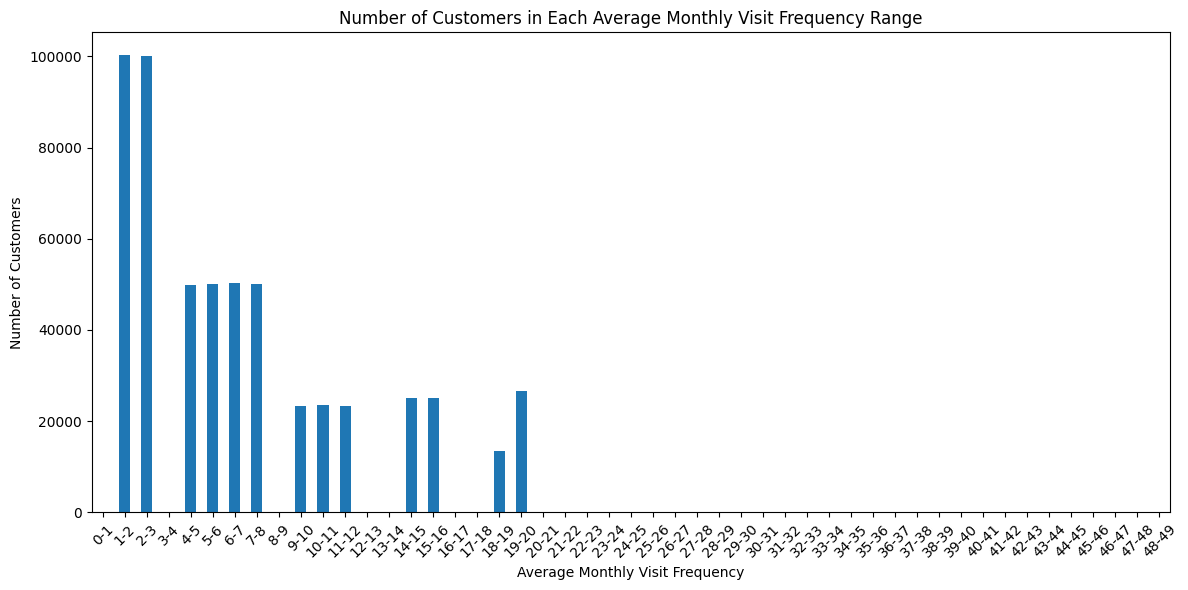

range
0-1           2
1-2      100263
2-3       99976
3-4           1
4-5       49959
5-6       49982
6-7       50306
7-8       50022
8-9           0
9-10      23255
10-11     23506
11-12     23352
12-13         0
13-14         0
14-15     25007
15-16     25036
16-17         0
17-18         0
18-19     13356
19-20     26636
20-21         0
21-22         0
22-23         1
23-24         0
24-25         0
25-26         0
26-27         0
27-28         0
28-29         0
29-30         0
30-31         0
31-32         0
32-33         0
33-34         0
34-35         0
35-36         0
36-37         0
37-38         0
38-39         0
39-40         0
40-41         0
41-42         0
42-43         0
43-44         0
44-45         0
45-46         0
46-47         0
47-48         0
48-49         0
Name: count, dtype: int64


In [26]:
plot_barCharts_2('average_monthly_visit_frequency', 'Average Monthly Visit Frequency', 1, 0, 50)

C:\Users\msi\AppData\Local\Temp\ipykernel_7088\4100806091.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['range'] = pd.cut(data[column_name], bins=bins, labels=labels, right=False)


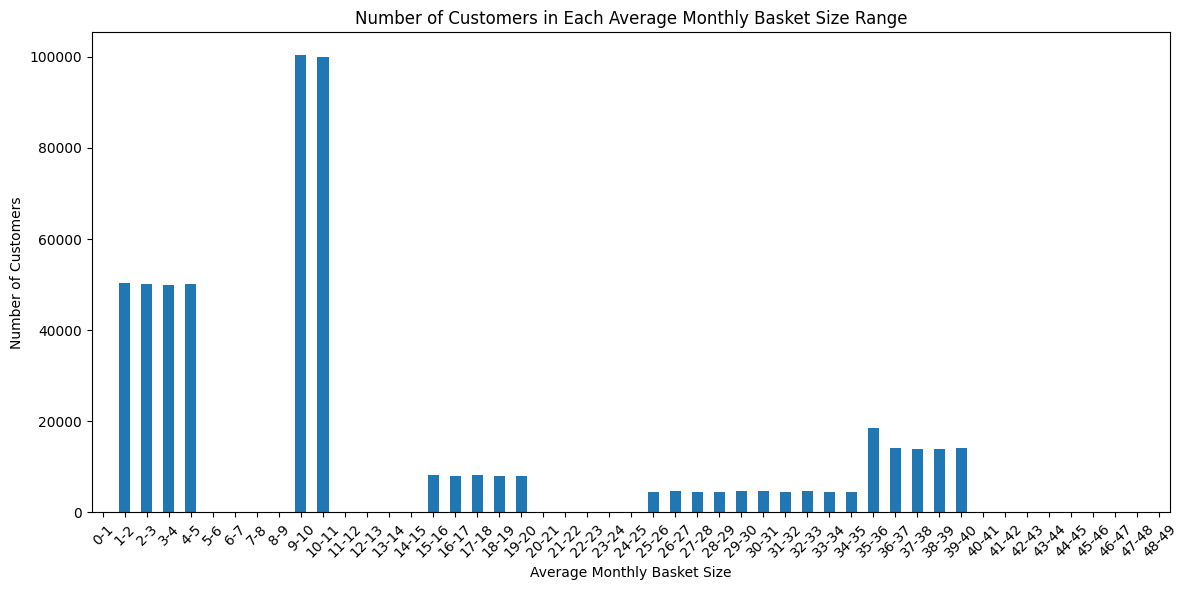

range
0-1           3
1-2       50256
2-3       50105
3-4       49792
4-5       50098
5-6           0
6-7           0
7-8           0
8-9           0
9-10     100359
10-11     99922
11-12         0
12-13         0
13-14         0
14-15         0
15-16      8092
16-17      7899
17-18      8084
18-19      7970
19-20      8032
20-21         0
21-22         0
22-23         0
23-24         0
24-25         0
25-26      4553
26-27      4639
27-28      4499
28-29      4526
29-30      4619
30-31      4598
31-32      4519
32-33      4598
33-34      4519
34-35      4493
35-36     18557
36-37     14019
37-38     13959
38-39     13938
39-40     14061
40-41         0
41-42         0
42-43         0
43-44         0
44-45         0
45-46         0
46-47         0
47-48         0
48-49         0
Name: count, dtype: int64


In [27]:
plot_barCharts_2('average_monthly_basket_size', 'Average Monthly Basket Size', 1, 0, 50)

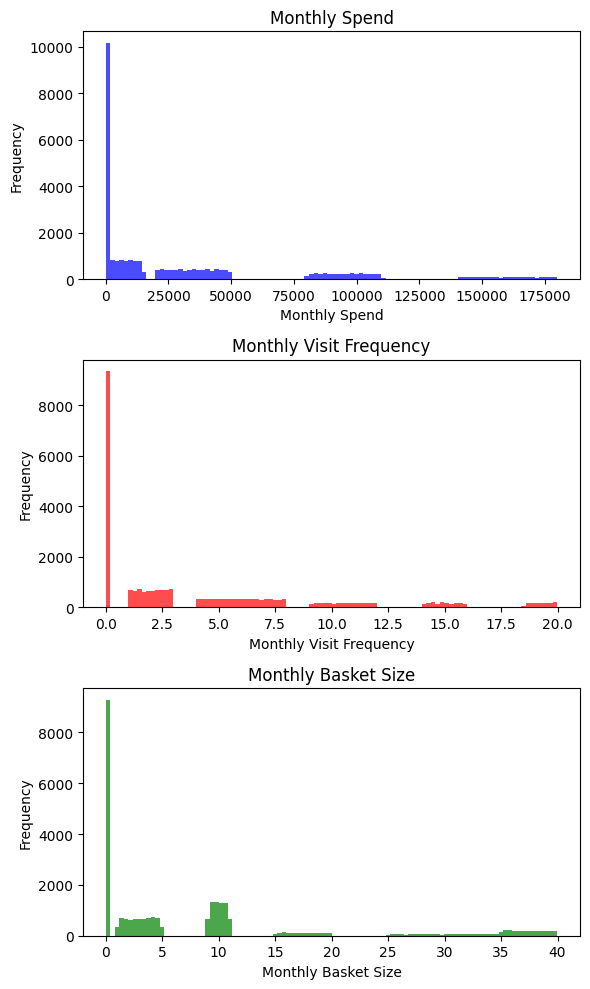

In [28]:
plt.figure(figsize=(6, 10))
plt.subplots_adjust(hspace=1)
plt.subplot(3, 1, 1)
plt.hist(nan_rows['average_monthly_spend'], bins=100, color='blue', alpha=0.7)
plt.title('Monthly Spend')
plt.xlabel('Monthly Spend')
plt.ylabel('Frequency')


plt.subplot(3, 1, 2)
plt.hist(nan_rows['average_monthly_visit_frequency'], bins=100, color='red', alpha=0.7)
plt.title('Monthly Visit Frequency')
plt.xlabel('Monthly Visit Frequency')
plt.ylabel('Frequency')

plt.subplot(3, 1, 3)
plt.hist(nan_rows['average_monthly_basket_size'], bins=100, color='green', alpha=0.7)
plt.title('Monthly Basket Size')
plt.xlabel('Monthly Basket Size')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Feature Selection

##  Loading Data

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from word2number import w2n
dataset_og = pd.read_csv("customer_dataset.csv")
CUS_ID = 'customer_id'
AVG_SPEND = 'average_monthly_spend'
AVG_VISIT = 'average_monthly_visit_frequency'
AVG_BASKET_SIZE = 'average_monthly_basket_size'
#handling non-numeric data converting them to numeric
def word_to_num(value):
    try:
        return w2n.word_to_num(value)
    except ValueError:
        if value.isdigit():
            return int(value)
        elif value.replace('.', '', 1).isdigit() and value.count('.') < 2:
            return float(value)
        return None
    
for column in dataset_og.columns:
    dataset_og[column] = dataset_og[column].apply(lambda x : word_to_num(str(x)))

dataset = dataset_og.drop_duplicates().dropna()
dataset.head()

C:\Users\msi\AppData\Local\Temp\ipykernel_7088\2911924489.py:5: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset_og = pd.read_csv("customer_dataset.csv")


,customer_id,average_monthly_spend,average_monthly_visit_frequency,average_monthly_basket_size
0,1,790.0,1.11,2.84
1,2,176875.0,15.74,33.83
3,4,38542.0,7.82,10.73
4,5,48712.0,7.51,10.04
5,6,172333.0,14.16,35.06


## Defining Cluster Thresholds Identified Preivously

In [30]:

class Basket_Sizes:
    LOW = (0,7)
    AVERAGE = (7,13)
    HIGH = (13,22)
    VERY_HIGH = (22,50)
    ranges = [LOW,AVERAGE,HIGH,VERY_HIGH]
    ranges_good = [LOW,AVERAGE,HIGH,VERY_HIGH]


    @classmethod
    def filter_set(cls,dataset,range):
        assert(range in cls.ranges)
        return dataset[(dataset[AVG_BASKET_SIZE] >= range[0]) & (dataset[AVG_BASKET_SIZE] < range[1])]

    @classmethod
    def get_mask(cls,dataset,range):
        assert(range in cls.ranges)
        return ((dataset[AVG_BASKET_SIZE] >= range[0]) & (dataset[AVG_BASKET_SIZE] < range[1]))

class Monthly_Spend:
    LOW = (0,17500)
    AVERAGE = (17500,65000)
    HIGH = (65000,125000)
    VERY_HIGH = (125000,200000)
    ranges = [LOW,AVERAGE,HIGH,VERY_HIGH]
    ranges_good = [LOW,AVERAGE,HIGH,VERY_HIGH]

    @classmethod
    def filter_set(cls,dataset,range):
        assert(range in cls.ranges)
        return dataset[(dataset[AVG_SPEND] >= range[0]) & (dataset[AVG_SPEND] < range[1])]

    @classmethod
    def get_mask(cls,dataset,range):
        assert(range in cls.ranges)
        return ((dataset[AVG_SPEND] >= range[0]) & (dataset[AVG_SPEND] < range[1]))


class Average_Visit:
    LOW = (0,3.7)
    AVERAGE_LOWER = (3.7,8.5)
    AVERAGE_HIGHER = (8.5,13)
    AVERAGE = (3.7,13)
    HIGH = (13,17)
    VERY_HIGH = (17,21)
    ranges =  [LOW,AVERAGE_LOWER,AVERAGE_HIGHER,HIGH,VERY_HIGH,AVERAGE]
    ranges_good =  [LOW,AVERAGE_LOWER,AVERAGE_HIGHER,HIGH,VERY_HIGH]

    @classmethod
    def filter_set(cls,dataset,range):
        assert(range in cls.ranges)
        return dataset[(dataset[AVG_VISIT] >= range[0]) & (dataset[AVG_VISIT] < range[1])]
    @classmethod
    def get_mask(cls,dataset,range):
        assert(range in cls.ranges)
        return ((dataset[AVG_VISIT] >= range[0]) & (dataset[AVG_VISIT] < range[1]))


## Checking Limiting and Borderline Cases in Threholds Manually

While the Clusters boarder that we have identified programatically (and verified by visual inspection) have good clear boarders there are a few data points that is better if closely and manually verified to ensure it has been given the correct group

In [31]:

data[(data[AVG_VISIT]>3) & (data[AVG_VISIT] < 4)]

,customer_id,average_monthly_spend,average_monthly_visit_frequency,average_monthly_basket_size,range
569999,244801,4225.0,3.4,1.92,1-2


In [32]:

data[(data[AVG_VISIT]>3) & (data[AVG_VISIT] < 4)]

,customer_id,average_monthly_spend,average_monthly_visit_frequency,average_monthly_basket_size,range
569999,244801,4225.0,3.4,1.92,1-2


## Fitering Using the Exact Rules Given in the Problem Statement

In [33]:

low_level_mask = Monthly_Spend.get_mask(dataset,Monthly_Spend.LOW) & Average_Visit.get_mask(dataset,Average_Visit.LOW) & Basket_Sizes.get_mask(dataset,Basket_Sizes.LOW)
medium_level_mask = Monthly_Spend.get_mask(dataset,Monthly_Spend.AVERAGE) & Average_Visit.get_mask(dataset,Average_Visit.AVERAGE) & Basket_Sizes.get_mask(dataset,Basket_Sizes.AVERAGE)
high_frequent_mask = Monthly_Spend.get_mask(dataset,Monthly_Spend.HIGH) & Average_Visit.get_mask(dataset,Average_Visit.VERY_HIGH) & Basket_Sizes.get_mask(dataset,Basket_Sizes.AVERAGE)
high_loyal_mask = Monthly_Spend.get_mask(dataset,Monthly_Spend.HIGH) & Average_Visit.get_mask(dataset,Average_Visit.AVERAGE) & Basket_Sizes.get_mask(dataset,Basket_Sizes.VERY_HIGH)
high_premium_mask = Monthly_Spend.get_mask(dataset,Monthly_Spend.VERY_HIGH) & Average_Visit.get_mask(dataset,Average_Visit.HIGH) & Basket_Sizes.get_mask(dataset,Basket_Sizes.HIGH)
print(low_level_mask.sum())
print(medium_level_mask.sum())
print(high_frequent_mask.sum())
print(high_loyal_mask.sum())
print(high_premium_mask.sum())

189981
190117
0
66407
0


From this we have verified the calim that we have made before that the basket value for the "High-end-frequent" and "High-end-premium" needs to be changed from the values given in the table in the problem statement. This can be verified by taking the datasets that do not fit the rules and plotting the distribution of the datasets that do not follow the rules and apply the rules for these two datasets except for the Basket size dataset and observing the distribution

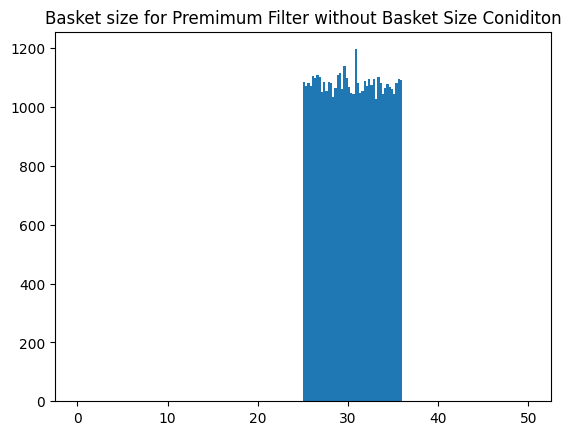

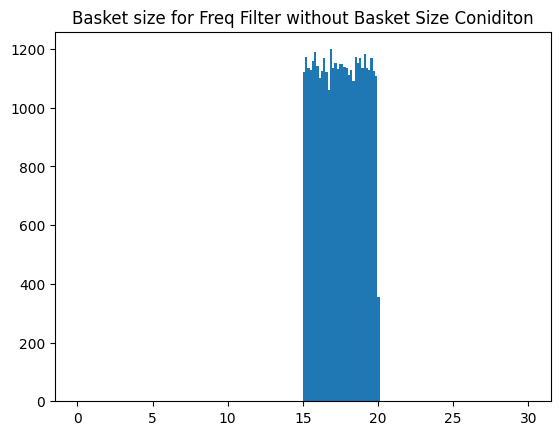

In [34]:
okay_masks = [low_level_mask,medium_level_mask,high_loyal_mask]
other_data = dataset[~(okay_masks[0] | okay_masks[1] | okay_masks[2])]


plt.title("Basket size for Premimum Filter without Basket Size Coniditon")
plt.hist(Monthly_Spend.filter_set(other_data,Monthly_Spend.VERY_HIGH)[AVG_BASKET_SIZE],bins=200,range=(0,50))
plt.show()
plt.title("Basket size for Freq Filter without Basket Size Coniditon")
plt.hist(Monthly_Spend.filter_set(other_data,Monthly_Spend.HIGH)[AVG_BASKET_SIZE],bins=200,range=(0,30))
plt.show()

In [35]:

high_frequent_mask = Monthly_Spend.get_mask(dataset,Monthly_Spend.HIGH) & Average_Visit.get_mask(dataset,Average_Visit.VERY_HIGH) & Basket_Sizes.get_mask(dataset,Basket_Sizes.HIGH)
high_premium_mask = Monthly_Spend.get_mask(dataset,Monthly_Spend.VERY_HIGH) & Average_Visit.get_mask(dataset,Average_Visit.HIGH) & Basket_Sizes.get_mask(dataset,Basket_Sizes.VERY_HIGH)
dataset[high_frequent_mask].describe()

,customer_id,average_monthly_spend,average_monthly_visit_frequency,average_monthly_basket_size
count,37975.000000,37975.000000,37975.000000,37975.000000
mean,281239.489849,94997.415036,19.247284,17.492247
std,161976.207837,8660.220172,0.434948,1.443141
min,74.000000,80000.000000,18.500000,15.000000
25%,140928.000000,87549.500000,18.870000,16.240000
50%,281125.000000,95004.000000,19.250000,17.500000
75%,421880.000000,102523.000000,19.630000,18.750000
max,559984.000000,109999.000000,19.990000,19.990000


## Proving additional clusters Identified in the Average Frequency correspond to actual features

Although the problem statement only identifies one average cluster for Frequency parameter from out prelimenary investigations we have shown that two seperate clusters are observable and furthermore that they actually can be effectively used to identify customer type. Now we will prove this claim. By applying the other two rules for a dataset with outliers removed and plotting the histograms

In [36]:
data = dataset
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    data = data[~((data[column] < (Q1 - 1.5 * IQR)) |(data[column] > (Q3 + 1.5 * IQR)))]
    return data
data = remove_outliers(data,AVG_SPEND)
data = remove_outliers(data,AVG_VISIT)
data = remove_outliers(data,AVG_BASKET_SIZE)

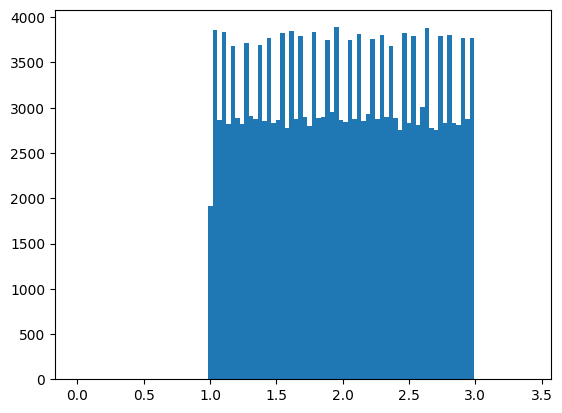

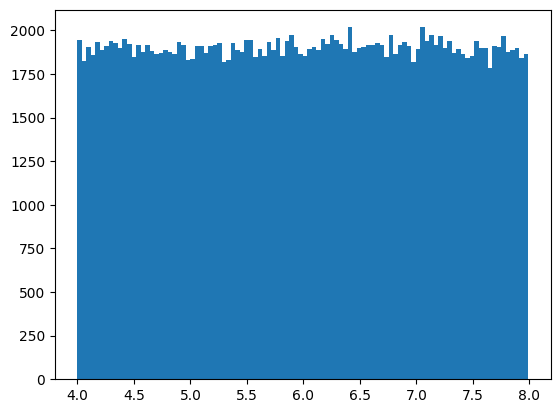

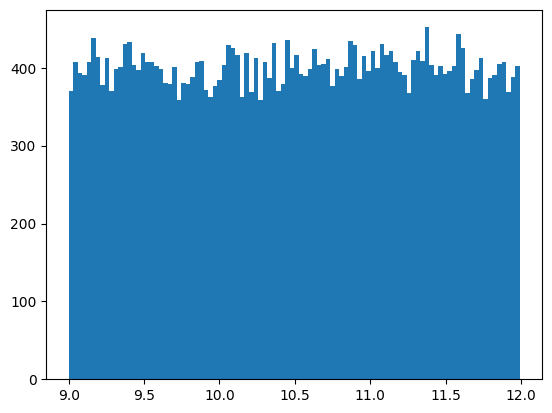

In [37]:

data1 = Monthly_Spend.filter_set(Basket_Sizes.filter_set(data,Basket_Sizes.LOW),Monthly_Spend.LOW)
plt.hist(data1[AVG_VISIT],bins=100)
plt.show()
data2 = Monthly_Spend.filter_set(Basket_Sizes.filter_set(data,Basket_Sizes.AVERAGE),Monthly_Spend.AVERAGE)
plt.hist(data2[AVG_VISIT],bins=100)
plt.show()
data3 = Monthly_Spend.filter_set(Basket_Sizes.filter_set(data,Basket_Sizes.VERY_HIGH),Monthly_Spend.HIGH)
plt.hist(data3[AVG_VISIT],bins=100)
plt.show()

In fact keeping these two as seperate clusters is highly benegicial especially since this alone can be used to identify between Medium and High-End Loyal Customers even if the two other parameters (Average Spending and Average Basket size) are missing.

This leads us to conclude that the table should be updated as 
| Customer Category  | Monthly Spend | Monthly Visit Frequency    | Monthly Basket Size |
|--------------------|---------------|----------------------------|---------------------|
| High end - Premium | Very High(3)  | High(3)                    | <del>High</del> Very High(3) |
| High end - Loyal   | High(2)       | Average (Average_Higher)(2)| Very High(3)        |
| High end - Frequent| High(2)       | Very High(4)               | <del>Average</del> High(2)   |
| Medium Level       | Average(1)    | Average (Average_Lower)(1) | Average(1)          |
| Low Level          | Low(0)        | Low(0)                     | Low(0)              |


# Analyzing Nature of Outliers and their Following of Rules

Now we will consider the dataset without the outliers to see if they obey the patterns observed

In [38]:

other_data = dataset[~(low_level_mask | medium_level_mask | high_loyal_mask | high_frequent_mask | high_premium_mask )]
other_data.describe()

,customer_id,average_monthly_spend,average_monthly_visit_frequency,average_monthly_basket_size
count,18.000000,1.800000e+01,18.000000,18.000000
mean,354434.666667,4.934703e+06,46.058333,69.655000
std,159311.270356,1.293920e+07,100.784055,110.472051
min,252.000000,0.000000e+00,1.250000,2.160000
25%,322879.500000,9.543150e+04,11.930000,12.427500
50%,325078.000000,1.489220e+05,15.310000,29.285000
75%,515194.750000,1.612676e+06,19.630000,37.470000
max,558101.000000,4.833000e+07,432.740000,385.040000


Most of the values that do not follow the rules are due to outliers so we will get rid of the outliers and see if there are columns which follow the rules

In [39]:

spend_anomaly = other_data[AVG_SPEND]>Monthly_Spend.VERY_HIGH[1]
basket_anomaly = other_data[AVG_BASKET_SIZE]>Basket_Sizes.VERY_HIGH[1]
visit_anomaly = other_data[AVG_VISIT]>Average_Visit.VERY_HIGH[1]

other_data[~(spend_anomaly | basket_anomaly | visit_anomaly)]

,customer_id,average_monthly_spend,average_monthly_visit_frequency,average_monthly_basket_size
325525,325526,0.0,9.36,36.42
515037,515038,0.0,15.35,30.02


From simple observation alone we can see that these two simply correspond to an entering error in the average monthly spend and actually belong to two clear categories if we consider the other two features

# Feature Engineering

Now we will give a numeric lable to each of the ranges for each of the parameters (known as the score) Outliers and Nan values are marked as known as (-1). (These can actually later be estimated atleast the range of them by considering the cluster that it belongs to)

In [40]:

classification_data = dataset_og.copy()
VISIT_SCORE = 'VISIT_SCORE'
BASKET_SCORE = 'BASKET_SCORE'
SPEND_SCORE = 'SPEND_SCORE'

classification_data[VISIT_SCORE] = -1
classification_data[BASKET_SCORE] = -1
classification_data[SPEND_SCORE] = -1

for i,rr in enumerate(Monthly_Spend.ranges_good):
    mask = Monthly_Spend.get_mask(classification_data,rr)
    classification_data.loc[mask,SPEND_SCORE] = i
#do the same for other two


for i,rr in enumerate(Basket_Sizes.ranges_good):
    mask = Basket_Sizes.get_mask(classification_data,rr)
    classification_data.loc[mask,BASKET_SCORE] = i


for i,rr in enumerate(Average_Visit.ranges_good):
    mask = Average_Visit.get_mask(classification_data,rr)
    classification_data.loc[mask,VISIT_SCORE] = i

classification_data

,customer_id,average_monthly_spend,average_monthly_visit_frequency,average_monthly_basket_size,VISIT_SCORE,BASKET_SCORE,SPEND_SCORE
0,1,790.0,1.11,2.84,0,0,0
1,2,176875.0,15.74,33.83,3,3,3
2,3,6812.0,2.11,NaN,0,-1,0
3,4,38542.0,7.82,10.73,1,1,1
4,5,48712.0,7.51,10.04,1,1,1
...,...,...,...,...,...,...,...
569995,341740,27428.0,4.91,9.42,1,1,1
569996,215276,141241.0,15.47,31.13,3,3,3
569997,11515,9183.0,2.09,4.61,0,0,0
569998,205260,35541.0,4.22,9.65,1,1,1


In [41]:

print(classification_data[VISIT_SCORE].value_counts())
print(classification_data[SPEND_SCORE].value_counts())
print(classification_data[BASKET_SCORE].value_counts())

VISIT_SCORE
 1    200269
 0    200242
 2     70113
 3     50043
 4     39992
-1      9341
Name: count, dtype: int64
SPEND_SCORE
 1    200311
 0    200108
 2    110153
 3     50031
-1      9397
Name: count, dtype: int64
BASKET_SCORE
 1    200281
 0    200254
 3    120097
 2     40077
-1      9291
Name: count, dtype: int64


Demonstrate that **There are no data points that have all feautres unknown**

In [42]:

no_data_mask = (classification_data[VISIT_SCORE]==-1) & (classification_data[SPEND_SCORE] == -1) & (classification_data[BASKET_SCORE] == -1)
classification_data[no_data_mask]

,customer_id,average_monthly_spend,average_monthly_visit_frequency,average_monthly_basket_size,VISIT_SCORE,BASKET_SCORE,SPEND_SCORE


Our Final Algorithm of Classifiation is very simple.

We have already identified the rules for each cluster by consdering the Problem Statement Table, The K-means Cluster Whisker plots. Fact that the decision boundaris can be written as logistic boundaries using and combination of decision inequalities for components idependantly (demonstrated using the cuboid shape of the cluster). The Nan Values also follow the same Law since they can clearly be seen to be projections of these cubes. Therefore we can simply collapes all feautre by assiging a number as for each range. Then we find the similarity to a certain Cluster rules using the following formula. 

Let the similarity between a customer and a Cluster be define by $S(\mathbf{x_i},\mathbf{c_j})$ Where $\mathbf{x_i}$ is the feautre vector defined for the $i^{th}$ customer, and $\mathbf{c_i}$ for the $j^{th}$ cluster. A feature vector is defined as $[\text{Average Spend Cluster Index}, \text{Average Basket Size Cluster Index}, \text{Average Visit Frequeny Index}]$



Now,
$$
S(x_i,c_j) = \sum_{k=0}^3{(x_i[k] == c_j[k])}
$$

where $k$ stands for the $k^{th}$ feature

That is the count of the entires where the cluster and customer has equal feature Indexes


Now the Cluster of the $i^{th}$ customer is given as,

$$
\text{Cluster of the $i^{th}$ customer} = \argmax_{j=0}^{5}{S(x_i,c_j)}
$$

## Calculating Cluster Similarities

In [43]:

score_given_data =classification_data.copy()

PREMIUM = 'PREMIUM'
LOYAL = 'LOYAL'
FREQ = 'FREQ'
MED = 'MED'
LOW = 'LOW'

PREMIUM_VEC = {SPEND_SCORE:3,VISIT_SCORE:3,BASKET_SCORE:3}
LOYAL_VEC = {SPEND_SCORE:2,VISIT_SCORE:2,BASKET_SCORE:3}
FREQ_VEC = {SPEND_SCORE:2,VISIT_SCORE:4,BASKET_SCORE:2}
MED_VEC = {SPEND_SCORE:1,VISIT_SCORE:1,BASKET_SCORE:1}
LOW_VEC = {SPEND_SCORE:0,VISIT_SCORE:0,BASKET_SCORE:0}

Types = [PREMIUM,LOYAL,FREQ,MED,LOW]
Vecs = [PREMIUM_VEC,LOYAL_VEC,FREQ_VEC,MED_VEC,LOW_VEC]
for ct,vec in zip(Types,Vecs):
    scores = (score_given_data[SPEND_SCORE]== vec[SPEND_SCORE]).astype(int) +(score_given_data[BASKET_SCORE]==vec[BASKET_SCORE]).astype(int) +(score_given_data[VISIT_SCORE]==vec[VISIT_SCORE]).astype(int)
    print(ct)
    score_given_data[ct] = scores

#get the column name that has the maximum value or values out of Types


MAX_CUSTOMER_TYPE_SCORE = 'MAX_SCORE'
score_given_data[MAX_CUSTOMER_TYPE_SCORE] = score_given_data[[PREMIUM,LOYAL,FREQ,MED,LOW]].max(axis=1)



PREMIUM
LOYAL
FREQ
MED
LOW


## Calculaing the Cluster Type

In [44]:

final_result = score_given_data.copy()
CUSTOMER_TYPE = 'CUSTOMER_TYPE'

final_result[CUSTOMER_TYPE] = final_result[[PREMIUM,LOYAL,FREQ,MED,LOW]].idxmax(axis=1)
final_result[CUSTOMER_TYPE].value_counts()

CUSTOMER_TYPE
MED        203581
LOW        203542
LOYAL       71275
PREMIUM     50887
FREQ        40715
Name: count, dtype: int64

In [45]:

final_result[[CUS_ID,CUSTOMER_TYPE]]

,customer_id,CUSTOMER_TYPE
0,1,LOW
1,2,PREMIUM
2,3,LOW
3,4,MED
4,5,MED
...,...,...
569995,341740,MED
569996,215276,PREMIUM
569997,11515,LOW
569998,205260,MED


# Saving the Data

In [46]:
saving_data = final_result.copy()[[CUS_ID,CUSTOMER_TYPE]]
assert(len(dataset_og)==len(saving_data))#making sure all the data is there
saving_data[CUSTOMER_TYPE] = saving_data[CUSTOMER_TYPE].map({PREMIUM:'High end - Premium',LOYAL:'High end - Loyal',FREQ:'High end - Frequent',MED:'Medium level',LOW:'Low level'})
saving_data.to_csv("final_results.csv",index=False)
saving_data.head()


,customer_id,CUSTOMER_TYPE
0,1,Low level
1,2,High end - Premium
2,3,Low level
3,4,Medium level
4,5,Medium level



# Checking the Results

In [47]:

validating_set = final_result.copy()

## Proving that there are no Customers who have more than one compatible cluster

In [48]:

duplicates = (score_given_data[Types[0]] == score_given_data[MAX_CUSTOMER_TYPE_SCORE]).astype(int)
for type in Types[1:]:
    duplicates  = (duplicates +(score_given_data[type] == score_given_data[MAX_CUSTOMER_TYPE_SCORE]).astype(int) )
duplicates.value_counts()

1    570000
Name: count, dtype: int64

Since all results have only one Max score there is no ambiguity

## Checking that the Distributions of Feature Values with the Final Classification Match with Expectation

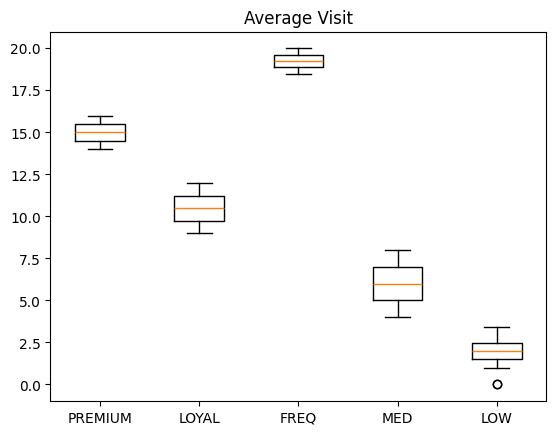

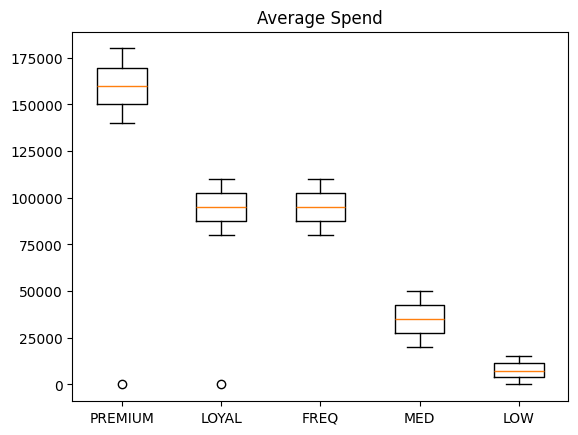

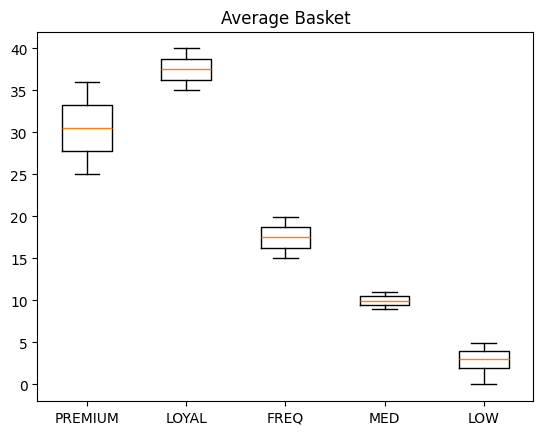

In [49]:

plt.title("Average Visit")
plt.boxplot(
    [validating_set[validating_set[CUSTOMER_TYPE]==type][AVG_VISIT].dropna()[validating_set[validating_set[CUSTOMER_TYPE]==type][AVG_VISIT].dropna().between(0,Average_Visit.VERY_HIGH[1])] for type in Types],
    labels=Types 

)
plt.show()

plt.title("Average Spend")
plt.boxplot(
    [validating_set[validating_set[CUSTOMER_TYPE]==type][AVG_SPEND].dropna()[validating_set[validating_set[CUSTOMER_TYPE]==type][AVG_SPEND].dropna().between(0,Monthly_Spend.VERY_HIGH[1])] for type in Types],
    labels=Types 

)
plt.show()

plt.title("Average Basket")
plt.boxplot(
    [validating_set[validating_set[CUSTOMER_TYPE]==type][AVG_BASKET_SIZE].dropna()[validating_set[validating_set[CUSTOMER_TYPE]==type][AVG_BASKET_SIZE].dropna().between(0,Basket_Sizes.VERY_HIGH[1])] for type in Types],
    labels=Types 

)
plt.show()

# Checking the Nature of the customers who had only similarity of 2

In [50]:
score_is_2 = validating_set[validating_set[MAX_CUSTOMER_TYPE_SCORE]==2]
score_is_2

,customer_id,average_monthly_spend,average_monthly_visit_frequency,average_monthly_basket_size,VISIT_SCORE,BASKET_SCORE,SPEND_SCORE,PREMIUM,LOYAL,FREQ,MED,LOW,MAX_SCORE,CUSTOMER_TYPE
2,3,6812.0,2.11,NaN,0,-1,0,0,0,0,0,2,2,LOW
7,8,12656.0,2.13,NaN,0,-1,0,0,0,0,0,2,2,LOW
24,25,41329.0,NaN,10.32,-1,1,1,0,0,0,2,0,2,MED
52,53,171010.0,NaN,35.03,-1,3,3,2,1,0,0,0,2,PREMIUM
53,54,104457.0,18.88,NaN,4,-1,2,0,1,2,0,0,2,FREQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559914,559915,45023.0,NaN,9.82,-1,1,1,0,0,0,2,0,2,MED
559945,559946,49533.0,5.87,NaN,1,-1,1,0,0,0,2,0,2,MED
559959,559960,NaN,5.80,9.87,1,1,-1,0,0,0,2,0,2,MED
559970,559971,95444.0,19.85,NaN,4,-1,2,0,1,2,0,0,2,FREQ


In [51]:
score_is_2.dropna().describe()

,customer_id,average_monthly_spend,average_monthly_visit_frequency,average_monthly_basket_size,VISIT_SCORE,BASKET_SCORE,SPEND_SCORE,PREMIUM,LOYAL,FREQ,MED,LOW,MAX_SCORE
count,18.000000,1.800000e+01,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.000000,18.0
mean,354434.666667,4.934703e+06,46.058333,69.655000,1.666667,1.277778,0.388889,0.888889,0.722222,0.444444,0.222222,0.444444,2.0
std,159311.270356,1.293920e+07,100.784055,110.472051,1.847096,1.673515,1.539247,0.963382,0.751904,0.783823,0.646762,0.783823,0.0
min,252.000000,0.000000e+00,1.250000,2.160000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
25%,322879.500000,9.543150e+04,11.930000,12.427500,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0
50%,325078.000000,1.489220e+05,15.310000,29.285000,2.500000,1.500000,0.000000,0.500000,1.000000,0.000000,0.000000,0.000000,2.0
75%,515194.750000,1.612676e+06,19.630000,37.470000,3.000000,3.000000,2.000000,2.000000,1.000000,0.750000,0.000000,0.750000,2.0
max,558101.000000,4.833000e+07,432.740000,385.040000,4.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0


We see that the ones that have given a similairyt score of 2 is the ones that are outliers the, two entires which had zero as spending be mistake (This is the above 18 rows), and entires with NA. Since we already know that the ones with NA only have one NA it is reasonable that all have a similarity score of 2. Furthermore it shows that even there there is no ambiguity

Thus our classification is Justified